# PROJECT STATEMENT
# ***PREDICT USER-DEFINED STOCK'S PRICE FOR THE NEXT DAY, WEEK, OR MONTH***

---

- We will use yfinance library to download stock data.
- However, the user will be unsure regarding the stock symbol, as yahoo finance includes extensions for stock symbol for exchanges outside USA territory.
- Hence, we will implement a module that will scrape suggestions for the search box on finance.yahoo.com and present it to the user. The suggestion include ticker symbol, company name, and the stock exchange it belongs to.
- Then, user can use the correct ticker symbol with another module which extracts historical stock data using yfinance
- To avoid blocking from yahoo finance, we will use code from yfinance's github page to implement a rate-limiting and request caching session system.
- Once the data is acquired, we will be able to plot it.
- We also want to consider other indicators to include with the stock data that will help us with forecasting stock price

---

## SCRAPING STOCK DATA

### Code to extract symbol suggestions from search bar in yahoo finance

In [15]:
# Importing necessary libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup
import re
import pandas as pd
import time

def search_symbols(search_str):
    # Input: search string
    # Output: No result found message or data frame of possible suggestions
    # Function to return data frame of suggestions appearing in yahoo finance website's search bar on entering a string

    start_time = time.time() # Tracking time when this function started running

    # Creating options object and setting preferences
    options=Options()
    options.set_preference("permissions.default.image", 2) # To limit image loading
    options.set_preference("permissions.default.video", 2) # To limit videos loading
    options.set_preference("media.autoplay.default", 1) # To limit autoplay media loading
    options.set_preference("media.autoplay.enabled.user-gestures-needed", False) # To stop autoplay of media
    options.add_argument("-headless") # Running browser in headless mode
    
    driver = webdriver.Firefox(options=options) # Launching Firefox browser with preferred options
    
    url = "https://finance.yahoo.com/" # URL of yahoo finance website
    
    driver.get(url) # Launching URL

    # Find search box and enter search string
    driver.find_element(By.ID, "yfin-usr-qry").send_keys(search_str)

    # Creating an explicit wait object to wait for 5 seconds
    wait = WebDriverWait(driver, 5)

    # Try for presense of 'Symbols' tab in search results and quit if explicit wait runs out and exit function
    # This is for cases where the search string has no symbol results
    try:
        sym = wait.until(EC.presence_of_element_located((By.XPATH, "//h3[contains(text(), 'Symbols')]")))
    except:
        driver.quit() # Quit driver
        print(f"This operation took {time.time() - start_time} seconds") # Print amount of time since start of function
        return "No relevant stocks found." # Return message that no stocks were found
    
    # Getting symbol data results by traversing XPATH
    sym_list = sym.find_element(By.XPATH, "../following-sibling::*[1]")

    # Extracting symbol data into soup
    soup = BeautifulSoup(sym_list.get_attribute("innerHTML"), "html.parser")
    
    driver.quit() # Quit driver as we've acquired soup

    items = soup.find_all('li') # Find every list item in symbols suggestion list

    # Creating lists for symbol, company name, and exchange
    symbol_list = []
    company_name_list = []
    exchange_list = []

    # Extracting symbol, company name, and exchange 
    for item in items:
        symbol = item.find('div', class_=re.compile(r'modules_quoteSymbol.*')).text.strip() # Extract Symbol
        # If stock is not publicly listed, it shows the symbol as private, in which case we ignore it
        if symbol == 'PRIVATE':
            continue
        symbol_list.append(symbol) # Add symbol to symbol list
        company_name = item.find('div', class_=re.compile(r'modules_quoteCompanyName.*')).text.strip() # Extract company name
        company_name_list.append(company_name) # Add company name to company name list
        exchange_name = item.find('span', class_=re.compile(r'modules_quoteSpan.*')).text.strip().split(' - ')[1] # Extract exchange
        exchange_list.append(exchange_name) # Add exchange name to exchange name list

    # Create a dataframe for the symbols, company names, and exchanges
    possible_symbols = pd.DataFrame({'Symbol':symbol_list, 'Company':company_name_list, 'Exchange':exchange_list})

    # If a company name is suggested by not listed (i.e. it is private), an empty data frame will be created
    # If an empty dataframe is created, we print the time taken by the function and return a message that no stocks were found
    if possible_symbols.shape[0] == 0:
        print(f"This operation took {time.time() - start_time} seconds")
        return "No relevant stocks found."
    # If dataframe is generated, print time taken by the function and return dataframe
    print(f"Getting these suggestions took {time.time() - start_time} seconds")
    return possible_symbols

In [16]:
# Get stock suggestions for string 'apple'
print(search_symbols('apple'))

    Symbol                       Company Exchange
0     AAPL                    Apple Inc.      NMS
1     APLE  Apple Hospitality REIT, Inc.      NYQ
2  AAPL.NE                    Apple Inc.      NEO
3    APC.F                    Apple Inc.      FRA
4  AAPL.MX                    Apple Inc.      MEX
Getting these suggestions took 31.94590139389038 seconds


In [17]:
# Get stock suggestions for string 'reliance'
print(search_symbols('reliance'))

        Symbol                          Company Exchange
0  RELIANCE.NS      Reliance Industries Limited      NSI
1           RS    Reliance Steel & Aluminum Co.      NYQ
2         RELI      Reliance Global Group, Inc.      NCM
3  RELINFRA.NS  Reliance Infrastructure Limited      NSI
4    RPOWER.NS           Reliance Power Limited      NSI
Getting these suggestions took 39.61316752433777 seconds


In [18]:
# Get stock suggestions for string 'byju'
print(search_symbols('byju'))

No relevant stocks found.
Getting these suggestions took 40.2602002620697 seconds


### Code to extract historical stock data 

In [49]:
import os, sys

import pandas as pd
from plotly import graph_objs as go

import yfinance as yf

from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter

# CachedLimiterSession class extends the CacheMixin, LimiterMixin, and Session classes.
# This class combines request caching (SQLiteCache) and rate limiting (Limiter) functionalities to prevent excessive API requests.
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

# An instance of CachedLimiterSession is created as session with a rate limit of 2 requests per 5 seconds and a caching backend using SQLite.
session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache")
    )

# suppresses the output to the standard output stream (stdout). 
# This class is used to silence the printing of unwanted information during the execution of the script.
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def plot_stock_data(stock, hist):
    # Input: yfinance stock ticker, dataframe of historical data
    # Provides interactive plot of the Open and Close stock prices

    # Create a plotly figure graphical object
    fig = go.Figure()
    # Add Scatter plots for Open and Close prices
    fig.add_trace(go.Scatter(x=hist.index, y=hist.Open, name="Stock Open"))
    fig.add_trace(go.Scatter(x=hist.index, y=hist.Close, name="Stock Close"))
    # Plotting Stock name as plot title (from stock ticker) with range slider for time
    fig.layout.update(title_text=f"{stock.info['longName']} Stock Price", width = 1150, height = 600, xaxis_rangeslider_visible=True)
    # Show plot
    fig.show()

In [50]:
# Loop to take ticker symbol from user and plot the Open and Close prices
# Enter quit to exit loop
while(True):
    symbol = input("Enter the stock symbol here: (Enter quit to exit)")
    # Break loop if 'quit' is entered
    if symbol.lower() == 'quit':
        break
    # Create a yfinance ticker object for user-defined symbol and using a session for rate-limiting and request caching
    stock = yf.Ticker(symbol, session=session)
    # If symbol is invalid, yfinance prints a long message regarding unavailability of the data and possible reasons, and returns an empty dataframe
    # To supress this message, we use HiddenPrints class
    with HiddenPrints():
        # Get entire available stock data using yfinance for user-defined symbol
        hist = stock.history(period="max")
    # If dataframe is empty, we print a message regarding unavailability of data, and loop again
    if hist.shape[0] == 0:
        print("No data found. Symbol is not listed.")
        continue
    # If historical data is retrieved, we plot it
    plot_stock_data(stock, hist)

Enter the stock symbol here: (Enter quit to exit) reliance.ns


Enter the stock symbol here: (Enter quit to exit) quit


In [88]:
# Code to get a dataframe of the historical stock data
# Take ticker symbol from user
symbol = input("Enter the stock symbol here: (Enter quit to exit)")
# Create a yfinance ticker object for user-defined symbol and using a session for rate-limiting and request caching
stock = yf.Ticker(symbol, session=session)
# If symbol is invalid, yfinance prints a long message regarding unavailability of the data and possible reasons, and returns an empty dataframe
# To supress this message, we use HiddenPrints class
with HiddenPrints():
    # Get entire available stock data using yfinance for user-defined symbol
    hist = stock.history(period="max")
# If dataframe is empty, we print a message regarding unavailability of data
if hist.shape[0] == 0:
    print("No data found. Symbol is not listed.")
# Dropping Dividends and Stock Splits columns as Dividends are very rare and price changes after Stock Splits are accounted for in yahoo finance
hist.drop(columns = ['Dividends', 'Stock Splits'], inplace = True)
# If historical data is retrieved, we print the dataframe
hist

Enter the stock symbol here: (Enter quit to exit) reliance.ns


Open         High          Low        Close   
Date                                                                            
1996-01-01 00:00:00+05:30    10.439799    10.495818    10.371049    10.477994  \
1996-01-02 00:00:00+05:30    10.452528    10.503454    10.320121    10.396510   
1996-01-03 00:00:00+05:30    10.567110    11.048360    10.452527    10.475444   
1996-01-04 00:00:00+05:30    10.376137    10.409239    10.238637    10.378683   
1996-01-05 00:00:00+05:30    10.337946    10.337946    10.218270    10.307390   
...                                ...          ...          ...          ...   
2023-06-12 00:00:00+05:30  2475.500000  2489.199951  2465.000000  2484.149902   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   
2023-06-14 00:00:00+05:30  2521.000000  2555.000000  2517.000000  2551.850098   
2023-06-15 00:00:00+05:30  2551.800049  2562.550049  2535.500000  2552.550049   
2023-06-16 00:00:00+05:30  2560.199951  2582.399902  2560.199951  2577.399902   

                              Volume  
Date                                  
1996-01-01 00:00:00+05:30   48051995  
1996-01-02 00:00:00+05:30   77875009  
1996-01-03 00:00:00+05:30   96602936  
1996-01-04 00:00:00+05:30  100099436  
1996-01-05 00:00:00+05:30   76935930  
...                              ...  
2023-06-12 00:00:00+05:30    2949893  
2023-06-13 00:00:00+05:30    5190958  
2023-06-14 00:00:00+05:30    6127509  
2023-06-15 00:00:00+05:30    5451926  
2023-06-16 00:00:00+05:30   11155180  

[6903 rows x 5 columns]

In [95]:
# Saturday and Sunday's data are missing. So we will get dates with daily frequency and fill 0 values for unavailable data
hist = hist.asfreq('D', 'ffill')

# Set the volume to 0 for the rows that correspond to weekends
hist['Volume'] = np.where((hist.index.weekday == 5) | (hist.index.weekday == 6), 0, hist['Volume'])

---
## FINDING OTHER INDICATORS

### 1. Relative Strength Index (RSI)

The RSI is a momentum oscillator that measures the speed and change of price movements. It compares the magnitude of recent gains to recent losses over a specified period of time. The period determines the number of historical data points considered in the calculation.

The RSI calculation involves calculating the average gains and losses, calculating the relative strength (RS = Avg Gains / Avg Losses), and then deriving the RSI using the formula: RSI = 100 - (100 / (1 + RS)).

RS values can range between 0 to infinity. 
- When a window has mostly gains, we have very large RS value
- When a window has mostly losses, we have very small RS value close to 0
- When a window has around the same amount of gains and losses, we have an RS value of 1

RSI values can range between 0 to 100.
- high gains, very large RS value, RSI value slightly smaller than 100
- high losses, very small RS value, RSI value close to 0
- same gains and losses, RS value 1, RSI value nearly half i.e. 50

So, average gain to loss ratio is stretched or squeezed to be between 0 and 100.

In [98]:
def calculate_rsi(data, window=14):
    # Input: stock data, window
    # output: RSI
    # Function to calculate RSI using historical closing prices of a stock
    close_delta = data['Close'].diff()
    up = close_delta.where(close_delta > 0, 0)
    down = -close_delta.where(close_delta < 0, 0)

    # Calculate the average gains and losses
    avg_gain = up.rolling(window).mean()
    avg_loss = down.rolling(window).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Calculate RSI using the close price and a window of 14 periods
hist['rsi'] = calculate_rsi(hist)

# Print dataframe
hist

Open         High          Low        Close   
Date                                                                            
1996-01-01 00:00:00+05:30    10.439799    10.495818    10.371049    10.477994  \
1996-01-02 00:00:00+05:30    10.452528    10.503454    10.320121    10.396510   
1996-01-03 00:00:00+05:30    10.567110    11.048360    10.452527    10.475444   
1996-01-04 00:00:00+05:30    10.376137    10.409239    10.238637    10.378683   
1996-01-05 00:00:00+05:30    10.337946    10.337946    10.218270    10.307390   
...                                ...          ...          ...          ...   
2023-06-12 00:00:00+05:30  2475.500000  2489.199951  2465.000000  2484.149902   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   
2023-06-14 00:00:00+05:30  2521.000000  2555.000000  2517.000000  2551.850098   
2023-06-15 00:00:00+05:30  2551.800049  2562.550049  2535.500000  2552.550049   
2023-06-16 00:00:00+05:30  2560.199951  2582.399902  2560.199951  2577.399902   

                              Volume        rsi  
Date                                             
1996-01-01 00:00:00+05:30   48051995        NaN  
1996-01-02 00:00:00+05:30   77875009        NaN  
1996-01-03 00:00:00+05:30   96602936        NaN  
1996-01-04 00:00:00+05:30  100099436        NaN  
1996-01-05 00:00:00+05:30   76935930        NaN  
...                              ...        ...  
2023-06-12 00:00:00+05:30    2949893  35.953682  
2023-06-13 00:00:00+05:30    5190958  50.271455  
2023-06-14 00:00:00+05:30    6127509  77.921702  
2023-06-15 00:00:00+05:30    5451926  81.711654  
2023-06-16 00:00:00+05:30   11155180  88.769056  

[10029 rows x 6 columns]

### 2. Moving Average Convergence Divergence (MACD)

The Moving Average Convergence Divergence (MACD) is a popular technical analysis indicator used to identify potential trend reversals, generate buy and sell signals, and gauge the strength of price movements. It consists of three main components: the MACD line, the signal line, and the histogram.

    MACD Line: The MACD line is calculated by subtracting the longer-term exponential moving average (EMA) from the shorter-term EMA. The most common settings for these EMAs are 26 and 12 periods, respectively, although they can be adjusted based on individual preferences or trading strategies. The MACD line represents the difference between these two EMAs and is used to capture the momentum of price changes.

    Signal Line: The signal line is a moving average (often a 9-period EMA) of the MACD line. It helps smooth out the MACD line and generate trading signals. When the MACD line crosses above the signal line, it is considered a bullish signal, indicating a potential buying opportunity. Conversely, when the MACD line crosses below the signal line, it is seen as a bearish signal, suggesting a potential selling opportunity.

    Histogram: The histogram is derived from the MACD line and the signal line. It represents the difference between the MACD line and the signal line and provides a visual representation of the convergence and divergence of the two lines. When the histogram bars are positive, it suggests upward momentum, and when they are negative, it indicates downward momentum. The height of the bars reflects the strength of the price movement.

By analyzing the MACD line, signal line, and histogram, traders can interpret the indicator to make trading decisions. For example, when the MACD line crosses above the signal line and the histogram bars turn positive, it may be considered a signal to buy. Conversely, when the MACD line crosses below the signal line and the histogram bars turn negative, it may be seen as a signal to sell.

It's worth noting that the MACD is a lagging indicator, meaning it may not provide timely signals during volatile market conditions or rapid price changes. Therefore, it is often used in conjunction with other indicators or tools to confirm trading decisions.decisions.

In [99]:
# Define a function to calculate MACD
def calculate_macd(data, short_period=12, long_period=26, signal_period=9):
    # Calculate the short-term EMA
    ema_short = data['Close'].ewm(span=short_period, adjust=False).mean()

    # Calculate the long-term EMA
    ema_long = data['Close'].ewm(span=long_period, adjust=False).mean()

    # Calculate the MACD line
    macd_line = ema_short - ema_long

    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    # Calculate the MACD histogram
    macd_histogram = macd_line - signal_line

    return macd_histogram

hist['macd'] = calculate_macd(hist)

In [100]:
hist

Open         High          Low        Close   
Date                                                                            
1996-01-01 00:00:00+05:30    10.439799    10.495818    10.371049    10.477994  \
1996-01-02 00:00:00+05:30    10.452528    10.503454    10.320121    10.396510   
1996-01-03 00:00:00+05:30    10.567110    11.048360    10.452527    10.475444   
1996-01-04 00:00:00+05:30    10.376137    10.409239    10.238637    10.378683   
1996-01-05 00:00:00+05:30    10.337946    10.337946    10.218270    10.307390   
...                                ...          ...          ...          ...   
2023-06-12 00:00:00+05:30  2475.500000  2489.199951  2465.000000  2484.149902   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   
2023-06-14 00:00:00+05:30  2521.000000  2555.000000  2517.000000  2551.850098   
2023-06-15 00:00:00+05:30  2551.800049  2562.550049  2535.500000  2552.550049   
2023-06-16 00:00:00+05:30  2560.199951  2582.399902  2560.199951  2577.399902   

                              Volume        rsi      macd  
Date                                                       
1996-01-01 00:00:00+05:30   48051995        NaN  0.000000  
1996-01-02 00:00:00+05:30   77875009        NaN -0.005200  
1996-01-03 00:00:00+05:30   96602936        NaN -0.003138  
1996-01-04 00:00:00+05:30  100099436        NaN -0.007836  
1996-01-05 00:00:00+05:30   76935930        NaN -0.014884  
...                              ...        ...       ...  
2023-06-12 00:00:00+05:30    2949893  35.953682 -1.547796  
2023-06-13 00:00:00+05:30    5190958  50.271455  0.773571  
2023-06-14 00:00:00+05:30    6127509  77.921702  4.071773  
2023-06-15 00:00:00+05:30    5451926  81.711654  5.866379  
2023-06-16 00:00:00+05:30   11155180  88.769056  8.152304  

[10029 rows x 7 columns]

### 3. Volatility

Volatility: Gives standard deviation of the rolling window. Indicates faith of the market in the stocks trend.e market.

In [101]:
def calculate_std(data, window=20):
    # Calculate the rolling standard deviation
    rolling_std = data['Close'].rolling(window=window).std()
    
    return rolling_std

# Calculate Volatility
hist['volatility'] = calculate_std(hist)

### 4. Inflation

Inflation can have both direct and indirect effects on stock prices. Here are a few ways in which inflation can impact stock prices:

    Purchasing Power: Inflation erodes the purchasing power of money over time. As the general price level rises, the value of each unit of currency decreases. This can lead to a decrease in consumer spending and corporate profits, which can ultimately affect stock prices negatively.

    Interest Rates: Central banks often respond to inflation by raising interest rates to curb rising prices. Higher interest rates can increase borrowing costs for businesses, making it more expensive for them to invest and expand. This can dampen corporate earnings and decrease stock prices.

    Investor Sentiment: Inflation can affect investor sentiment and confidence in the market. Uncertainty about future inflation rates can lead to volatility and fluctuations in stock prices. Investors may become cautious or seek inflation-hedging assets, which can impact the demand and supply of stocks.

    Industry and Sector Performance: Inflation can impact different industries and sectors differently. Some sectors, such as utilities and consumer staples, are often considered defensive during inflationary periods because they provide essential goods and services. On the other hand, industries like technology and discretionary consumer goods may be more sensitive to inflation due to higher input costs. As a result, the performance of different sectors during inflationary periods can affect the overall stock market.

    Valuation Metrics: Inflation can impact the valuation of stocks. Higher inflation may lead to higher discount rates used to value future cash flows, resulting in lower stock valuations. Moreover, rising inflation can also increase the cost of goods and services, potentially reducing profit margins and affecting price-to-earnings ratios.

It's important to note that the relationship between inflation and stock prices is complex and can be influenced by various factors such as economic conditions, monetary policy, investor expectations, and market sentiment. Additionally, different companies and sectors may be affected differently by inflation. Therefore, understanding the specific dynamics of the market and conducting thorough analysis is crucial to assess the potential impact of inflation on stock prices.

In [102]:
import wbdata

# Importing a data frame created from scraped stock data from 2017 from finance.yahoo.com
# It contains exchanges and their countries
exc_country_df = pd.read_csv('exchanges_by_country.csv')

# Importing a data frame created using countries and their codes from World bank's website
countries = pd.read_csv("country_codes.csv")

# Extracting country from exc_country_df by matching to stock's exchange
stock_country = exc_country_df[exc_country_df.exchange == stock.info['exchange']].country.values[0]

# Extracting country code from countries data frame by matching to the stock's country
stock_country_code = countries[countries.Country == stock_country].Code.values[0]

# Getting historical inflation data from wbdata library using the extracted country code
stock_country_inflation_data = wbdata.get_dataframe(indicators={'FP.CPI.TOTL.ZG':'Inflation'}, 
                                                    country=stock_country_code, 
                                                    freq = 'M', 
                                                    convert_date = True)

# Extract year from the index of stock_country_inflation_data
stock_country_inflation_data['year'] = stock_country_inflation_data.index.year

# Extract year from the index of hist
hist['year'] = hist.index.year

# Merge the two data frames based on the year
temp_df = pd.merge(hist, stock_country_inflation_data, how='left', on='year')
# Setting index on hist to the new dataframe
temp_df.index = hist.index
# Assigning new dataframe to hist
hist = temp_df
# Drop the unnecessary columns
hist.drop(['year'], axis=1, inplace=True)

In [103]:
hist

Open         High          Low        Close   
Date                                                                            
1996-01-01 00:00:00+05:30    10.439799    10.495818    10.371049    10.477994  \
1996-01-02 00:00:00+05:30    10.452528    10.503454    10.320121    10.396510   
1996-01-03 00:00:00+05:30    10.567110    11.048360    10.452527    10.475444   
1996-01-04 00:00:00+05:30    10.376137    10.409239    10.238637    10.378683   
1996-01-05 00:00:00+05:30    10.337946    10.337946    10.218270    10.307390   
...                                ...          ...          ...          ...   
2023-06-12 00:00:00+05:30  2475.500000  2489.199951  2465.000000  2484.149902   
2023-06-13 00:00:00+05:30  2495.000000  2523.449951  2486.250000  2520.850098   
2023-06-14 00:00:00+05:30  2521.000000  2555.000000  2517.000000  2551.850098   
2023-06-15 00:00:00+05:30  2551.800049  2562.550049  2535.500000  2552.550049   
2023-06-16 00:00:00+05:30  2560.199951  2582.399902  2560.199951  2577.399902   

                              Volume        rsi      macd  volatility   
Date                                                                    
1996-01-01 00:00:00+05:30   48051995        NaN  0.000000         NaN  \
1996-01-02 00:00:00+05:30   77875009        NaN -0.005200         NaN   
1996-01-03 00:00:00+05:30   96602936        NaN -0.003138         NaN   
1996-01-04 00:00:00+05:30  100099436        NaN -0.007836         NaN   
1996-01-05 00:00:00+05:30   76935930        NaN -0.014884         NaN   
...                              ...        ...       ...         ...   
2023-06-12 00:00:00+05:30    2949893  35.953682 -1.547796   24.588895   
2023-06-13 00:00:00+05:30    5190958  50.271455  0.773571   24.130033   
2023-06-14 00:00:00+05:30    6127509  77.921702  4.071773   25.987348   
2023-06-15 00:00:00+05:30    5451926  81.711654  5.866379   29.283113   
2023-06-16 00:00:00+05:30   11155180  88.769056  8.152304   34.768743   

                           Inflation  
Date                                  
1996-01-01 00:00:00+05:30   8.977152  
1996-01-02 00:00:00+05:30   8.977152  
1996-01-03 00:00:00+05:30   8.977152  
1996-01-04 00:00:00+05:30   8.977152  
1996-01-05 00:00:00+05:30   8.977152  
...                              ...  
2023-06-12 00:00:00+05:30        NaN  
2023-06-13 00:00:00+05:30        NaN  
2023-06-14 00:00:00+05:30        NaN  
2023-06-15 00:00:00+05:30        NaN  
2023-06-16 00:00:00+05:30        NaN  

[10029 rows x 9 columns]

### 5. Lending interest rate (%)

The lending interest rate can indirectly influence stock price forecasting through its impact on the overall economic conditions and investor behavior. Here are a few ways in which the lending interest rate can potentially affect stock price forecasting:

    Cost of Capital: The lending interest rate affects the cost of capital for companies. When the lending interest rate is low, borrowing becomes cheaper, which can stimulate business expansion, investment, and overall economic growth. This can positively impact company earnings and potentially lead to higher stock prices. Conversely, higher lending interest rates can increase borrowing costs for companies, potentially dampening their profitability and impacting stock prices negatively.

    Investor Sentiment: Changes in lending interest rates can influence investor sentiment and risk appetite. When lending rates are low, investors may be more inclined to borrow money for investments, including stocks, as the cost of borrowing is relatively lower. This increased demand for stocks can potentially drive up stock prices. Conversely, higher lending rates can make borrowing for investment purposes less attractive, potentially leading to reduced demand for stocks and lower prices.

    Discount Rate: The lending interest rate can impact the discount rate used in discounted cash flow (DCF) analysis, a commonly used valuation method for stocks. The discount rate is used to determine the present value of future cash flows, and it typically incorporates the risk-free rate (such as government bond yields) plus a risk premium. If the lending interest rate increases, it may lead to higher risk-free rates and, consequently, a higher discount rate. This can result in a lower present value of future cash flows, potentially impacting stock valuations and forecasting.

    Economic Conditions: Changes in lending interest rates reflect the monetary policy decisions of central banks, which are often driven by economic conditions. Lower lending rates are typically associated with accommodative monetary policy, aimed at stimulating economic growth. In such an environment, companies may benefit from increased access to capital, improved consumer spending, and higher corporate earnings, potentially positively impacting stock prices. Conversely, higher lending rates can be a sign of tightening monetary policy, which may indicate a less favorable economic environment and potentially impact stock prices negatively.

It's important to note that while the lending interest rate can have an indirect influence on stock prices, predicting stock prices accurately is a complex task that requires considering a wide range of factors, including company-specific fundamentals, market sentiment, and broader economic conditions. Therefore, it's recommended to use a comprehensive approach that incorporates multiple indicators and analysis techniques for stock price forecasting.tock prices.

In [104]:
# Getting historical interest spread data from wbdata library using the extracted country code
stock_country_lending_interest_rate_data = wbdata.get_dataframe(indicators={'FR.INR.LEND':'Lending_interest_rate'}, 
                                                    country=stock_country_code, 
                                                    freq = 'M', 
                                                    convert_date = True)

# Extract year from the index of stock_country_inflation_data
stock_country_lending_interest_rate_data['year'] = stock_country_lending_interest_rate_data.index.year

# Extract year from the index of hist
hist['year'] = hist.index.year

# Merge the two data frames based on the year
temp_df = pd.merge(hist, stock_country_lending_interest_rate_data, how='left', on='year')
# Setting index on hist to the new dataframe
temp_df.index = hist.index
# Assigning new dataframe to hist
hist = temp_df
# Drop the unnecessary columns
hist.drop(['year'], axis=1, inplace=True)

---
## EXPLORATORY DATA ANALYSIS

In [105]:
# Getting feature info
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10029 entries, 1996-01-01 00:00:00+05:30 to 2023-06-16 00:00:00+05:30
Freq: D
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open                   10029 non-null  float64
 1   High                   10029 non-null  float64
 2   Low                    10029 non-null  float64
 3   Close                  10029 non-null  float64
 4   Volume                 10029 non-null  int64  
 5   rsi                    10016 non-null  float64
 6   macd                   10029 non-null  float64
 7   volatility             10010 non-null  float64
 8   Inflation              9497 non-null   float64
 9   Lending_interest_rate  9862 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 861.9 KB


In [106]:
# Getting number of na value for each feature
hist.isna().sum()

Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
rsi                       13
macd                       0
volatility                19
Inflation                532
Lending_interest_rate    167
dtype: int64

In [107]:
# Droping rows with na values
# Recent data is lost for now as world bank doesn't have data for the latest 1 or 2 years
hist.dropna(inplace = True)

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
corr = hist.corr()
np.fill_diagonal(corr.values, 0)

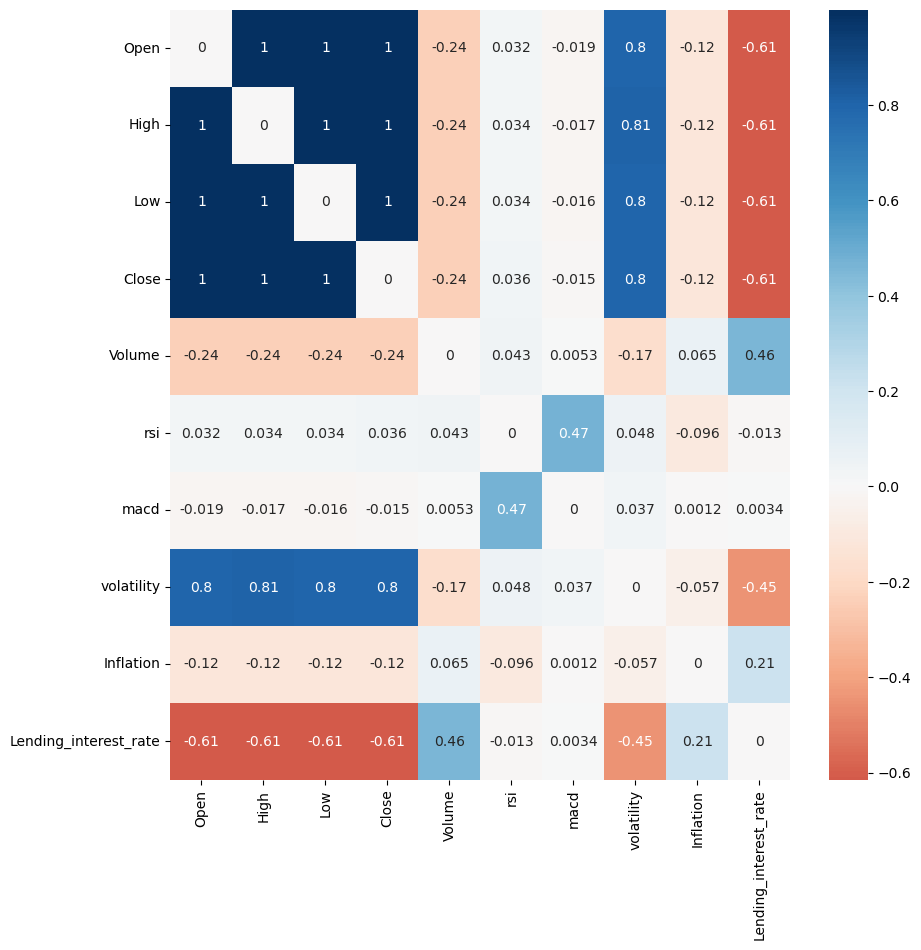

In [110]:
plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True, cmap = 'RdBu', center = 0)
plt.show()

In [111]:
hist.describe()

Open         High          Low        Close        Volume   
count  9478.000000  9478.000000  9478.000000  9478.000000  9.478000e+03  \
mean    456.007826   461.705467   449.781696   455.513218  2.077584e+07   
std     547.943744   554.067196   541.070897   547.249086  4.288189e+07   
min       7.791652     7.827302     7.743273     7.827302  0.000000e+00   
25%      40.724616    41.194516    40.254712    40.671900  0.000000e+00   
50%     372.659437   377.382134   367.331038   372.740219  7.710130e+06   
75%     491.733941   498.280999   485.438618   491.530701  2.106059e+07   
max    2734.517166  2743.091369  2699.871396  2723.649902  6.686620e+08   

               rsi         macd   volatility    Inflation   
count  9478.000000  9478.000000  9478.000000  9478.000000  \
mean     52.847240    -0.007689    12.025256     6.495823   
std      20.319905     3.626833    16.872491     2.808250   
min       0.000000   -23.986265     0.111075     3.328173   
25%      37.894705    -0.649764     1.264660     4.009436   
50%      53.118790    -0.002065     6.793084     5.131407   
75%      67.896947     0.628817    14.610363     8.911793   
max     100.000000    27.465769   136.050397    13.230839   

       Lending_interest_rate  
count            9478.000000  
mean               11.167870  
std                 1.775359  
min                 8.333350  
25%                 9.672500  
50%                10.750000  
75%                12.291667  
max                15.958333

In [112]:
cols = hist.columns.tolist()

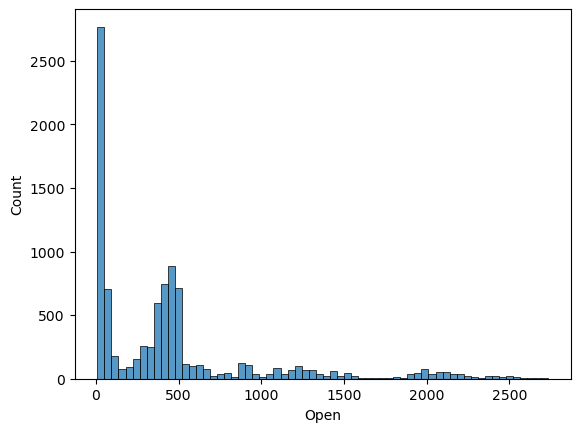

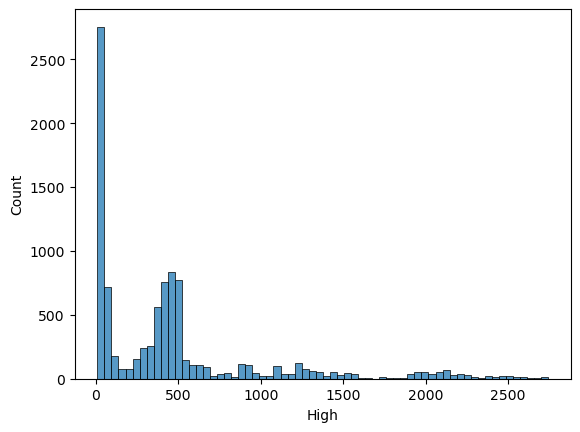

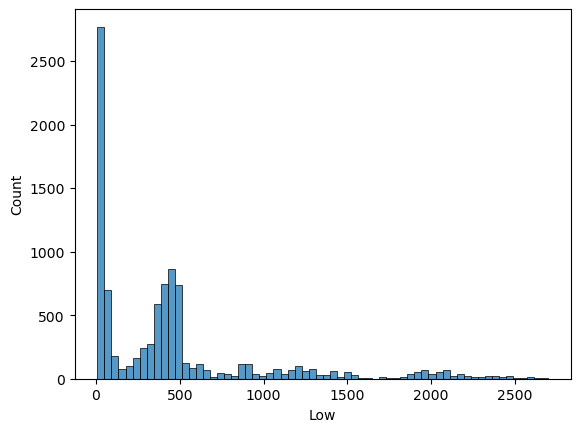

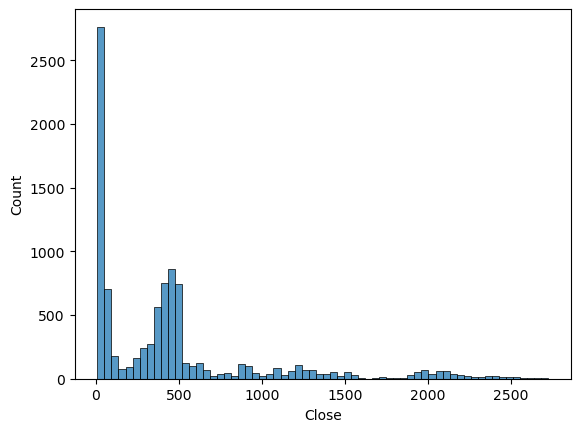

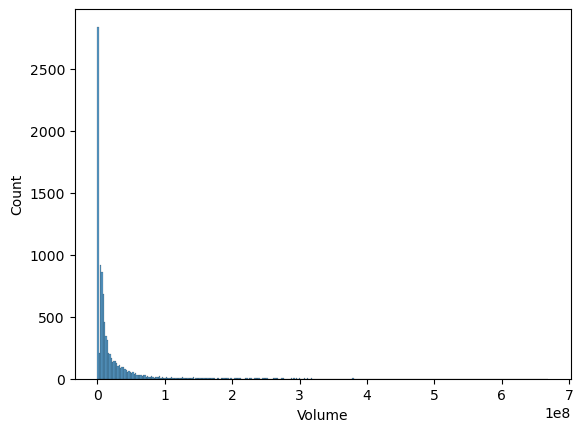

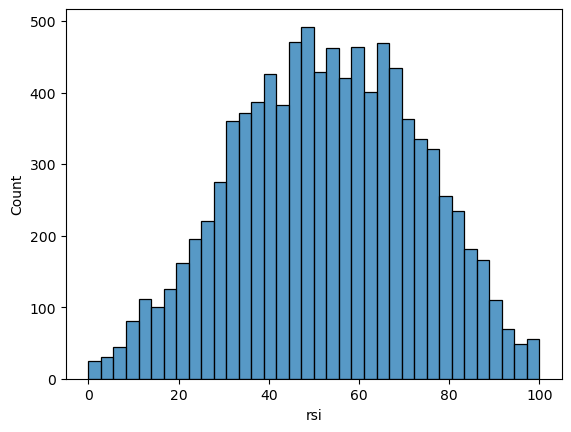

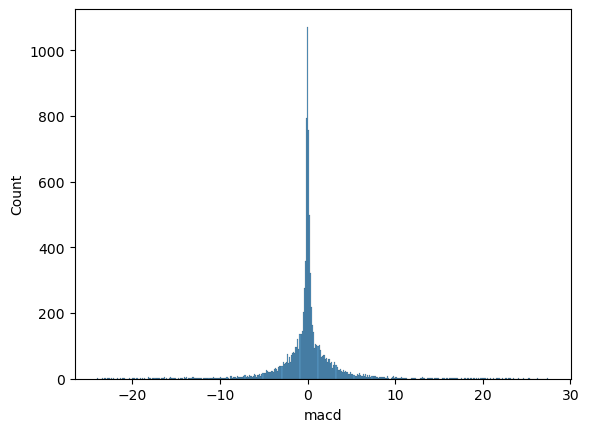

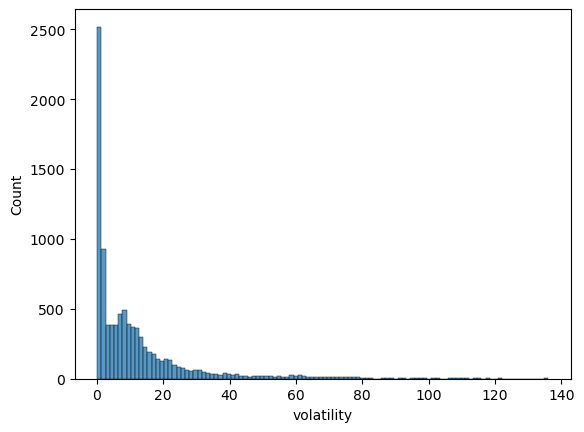

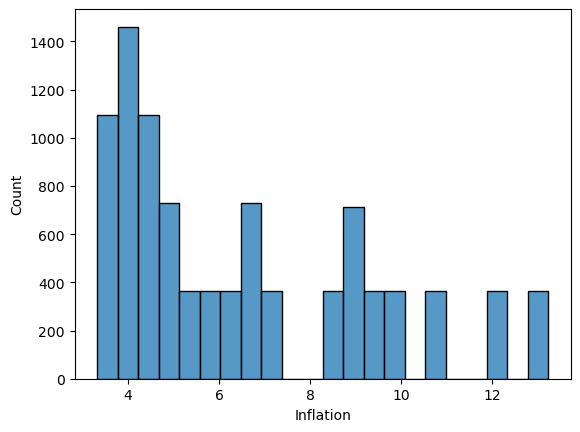

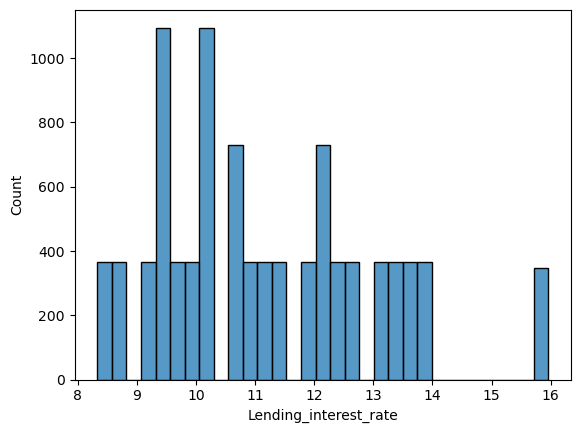

In [113]:
for col in cols:
    sns.histplot(hist, x = col)
    plt.show()

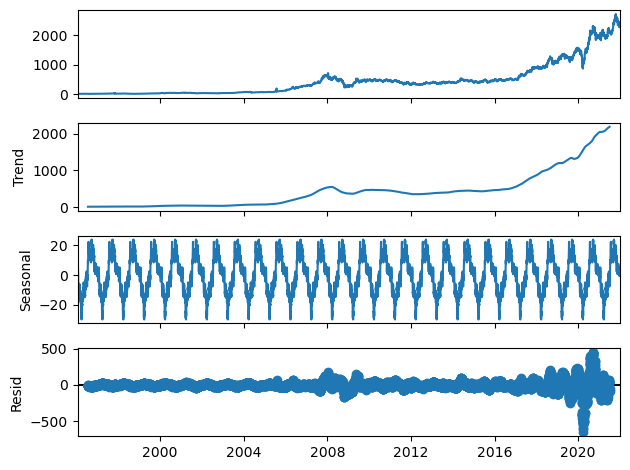

In [118]:
# Getting timeseries decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(hist[['Close']], period = 365).plot()
plt.show()

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

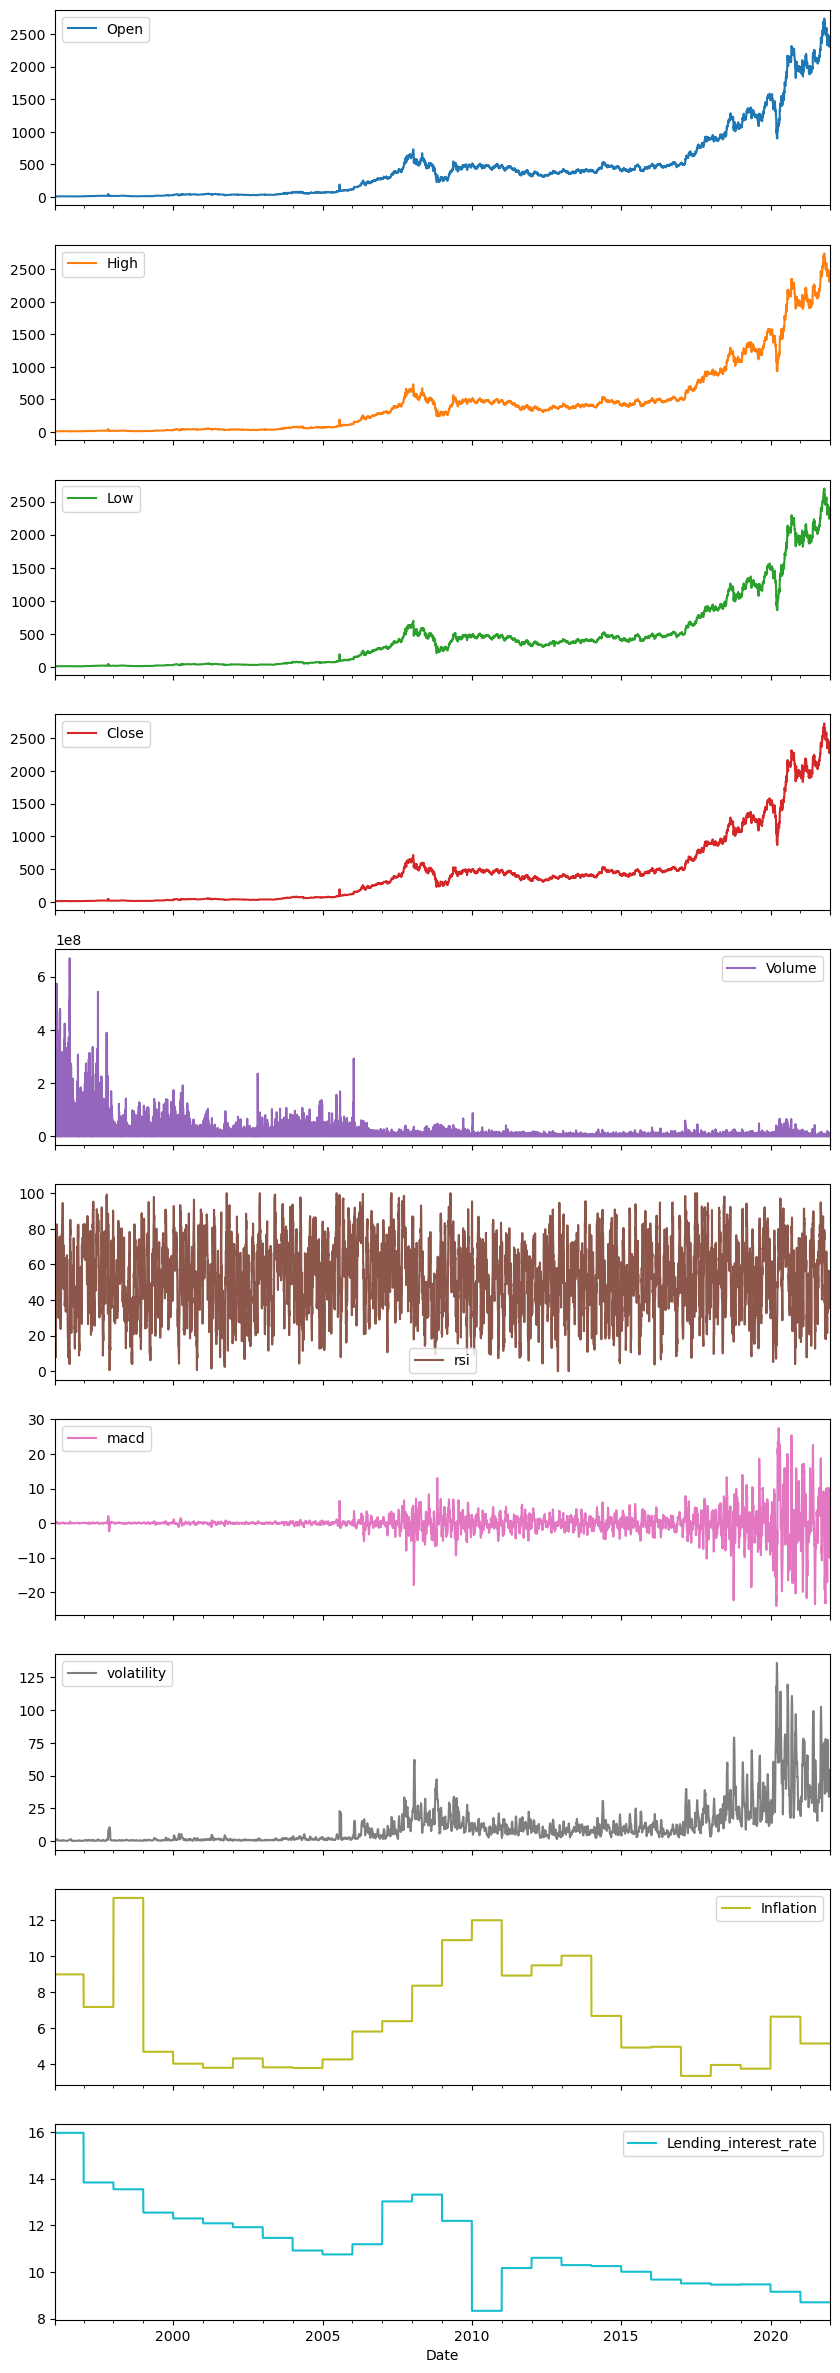

In [119]:
hist.plot(subplots = True, figsize=(10, 30))

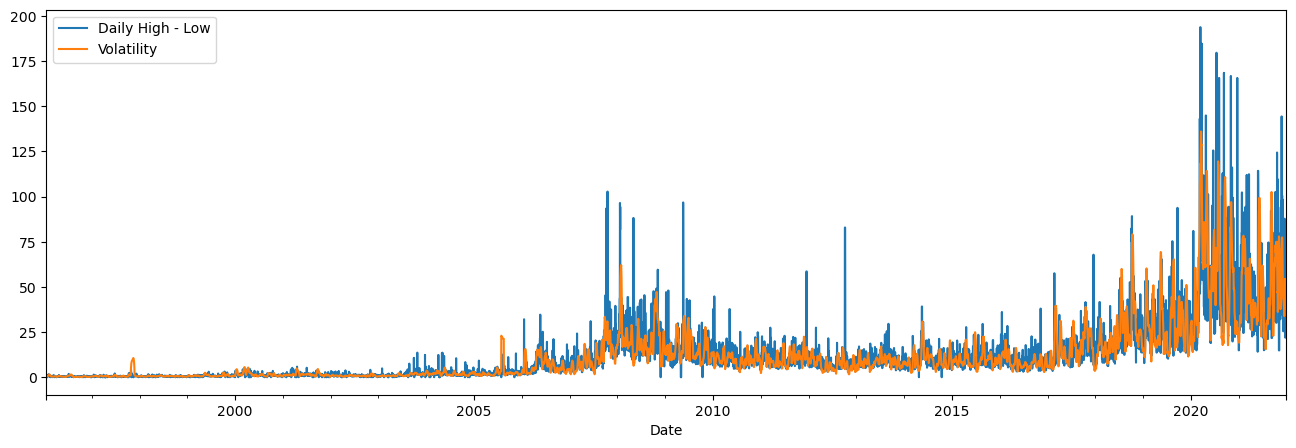

In [120]:
(hist.High - hist.Low).plot(figsize=(16,5), label = 'Daily High - Low')
hist.volatility.plot(figsize=(16,5), label = 'Volatility')
plt.legend()

Volatility captured using moving window of 20 days supports the difference of daily highest and lowest prices

Text(0.5, 1.0, "Difference between today's Closing price and tomorrow's Opening price")

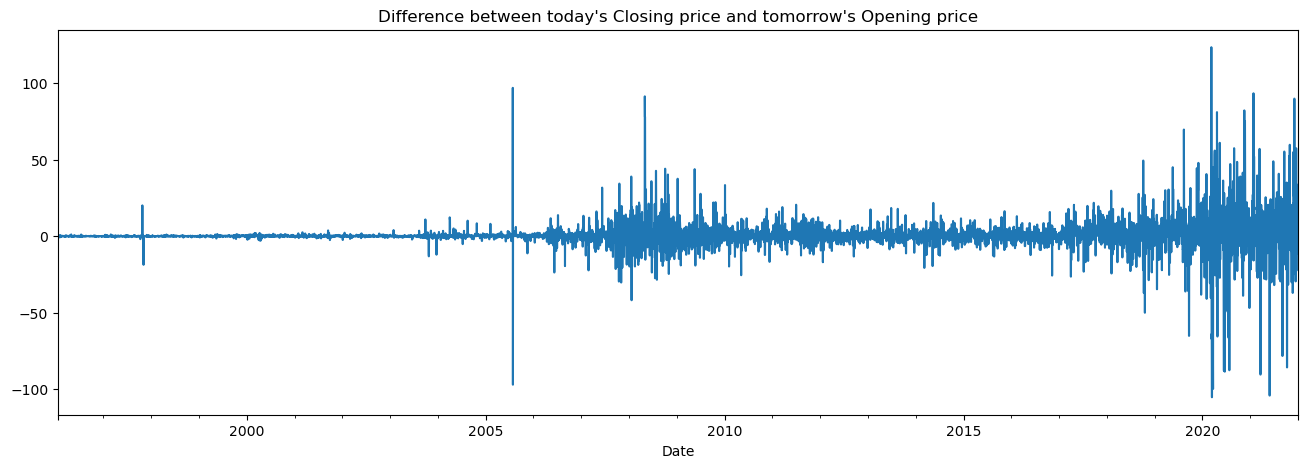

In [121]:
(hist.Open.shift(-1) - hist.Close).plot(figsize=(16,5))
plt.title('Difference between today\'s Closing price and tomorrow\'s Opening price')

During the time the market is closed, factors like company related news, overall market trend, macro factors like inflation, and market movement of overseas exchanges that are active when this exchange is closed, affect the price of the stock. So tomorrow's opening price is not always the same as today's closing price. And the difference indicate the impact of external factors on the stock's value.

Text(0.5, 1.0, 'Movement of price from start to end of the day')

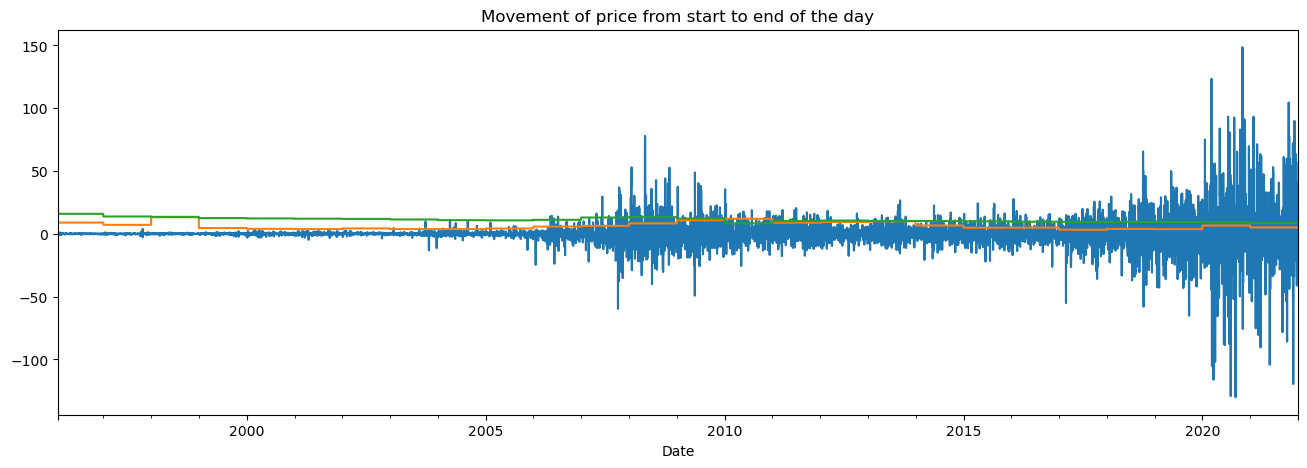

In [122]:
(hist.Open - hist.Close).plot(figsize=(16,5))
hist.Inflation.plot(figsize=(16,5))
hist.Lending_interest_rate.plot(figsize=(16,5))
plt.title('Movement of price from start to end of the day')

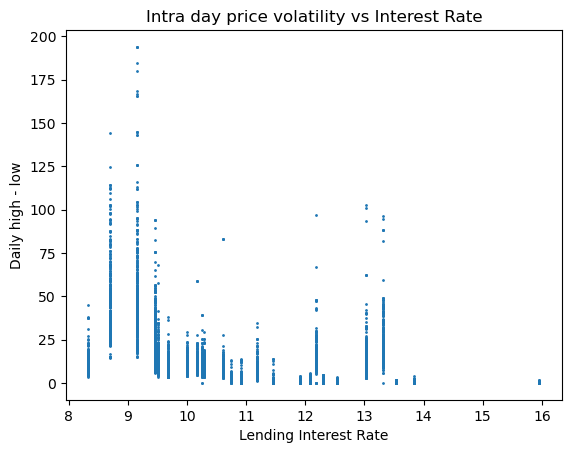

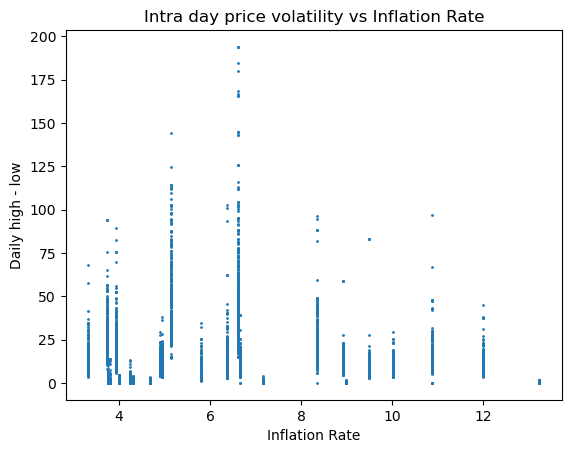

In [123]:
plt.scatter(hist.Lending_interest_rate, hist.High - hist.Low, s = 1)
plt.ylabel("Daily high - low")
plt.xlabel("Lending Interest Rate")
plt.title("Intra day price volatility vs Interest Rate")
plt.show()
plt.scatter(hist.Inflation, hist.High - hist.Low, s = 1)
plt.ylabel("Daily high - low")
plt.xlabel("Inflation Rate")
plt.title("Intra day price volatility vs Inflation Rate")
plt.show()

In [124]:
latest = hist[hist.index.year >= 2016]

C:\Users\harsh\AppData\Local\Temp\ipykernel_932\1676298173.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='year', ylabel='Close'>

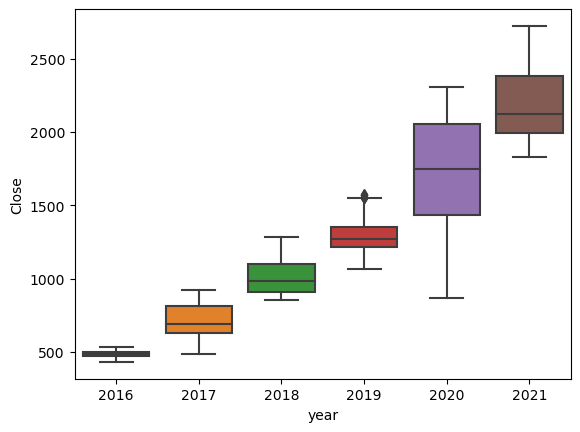

In [125]:
latest['year'] = latest.index.year
sns.boxplot(latest, x = 'year', y = 'Close')

C:\Users\harsh\AppData\Local\Temp\ipykernel_932\4040764517.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='quarter', ylabel='Close'>

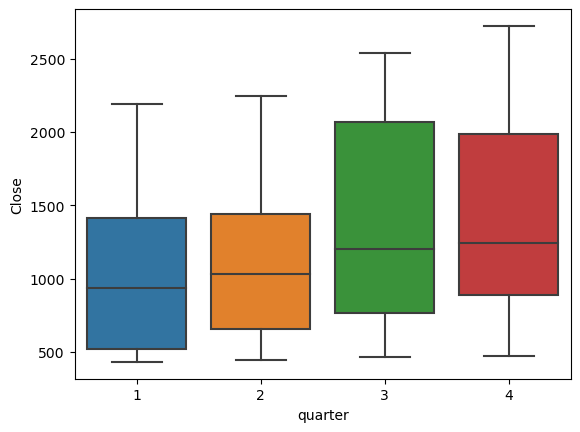

In [126]:
latest['quarter'] = latest.index.quarter
sns.boxplot(latest, x = 'quarter', y = 'Close')

C:\Users\harsh\AppData\Local\Temp\ipykernel_932\1247869609.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='month', ylabel='Close'>

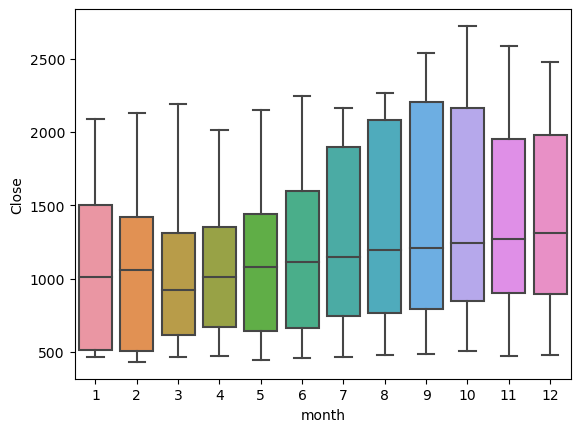

In [127]:
latest['month'] = latest.index.month
sns.boxplot(latest, x = 'month', y = 'Close')

C:\Users\harsh\AppData\Local\Temp\ipykernel_932\2932699514.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='weekday', ylabel='Close'>

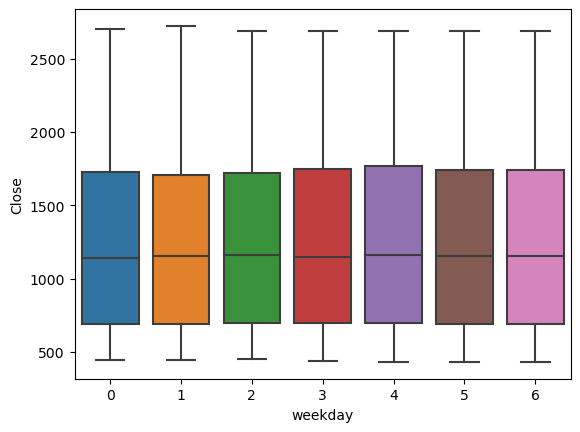

In [128]:
latest['weekday'] = latest.index.weekday
sns.boxplot(latest, x = 'weekday', y = 'Close')

Days : 7


<Figure size 2000x1000 with 0 Axes>

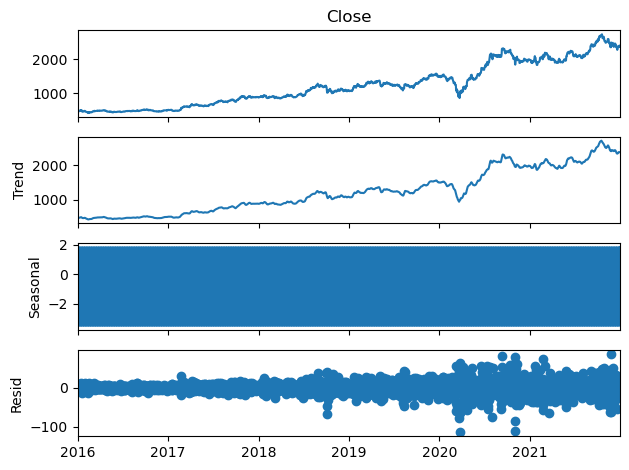

Days : 30


<Figure size 2000x1000 with 0 Axes>

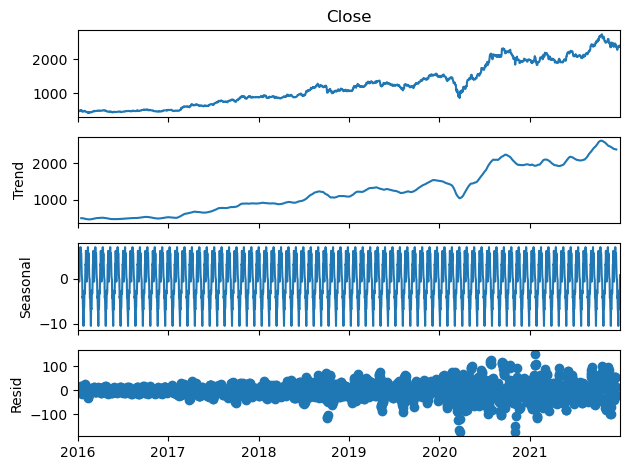

Days : 120


<Figure size 2000x1000 with 0 Axes>

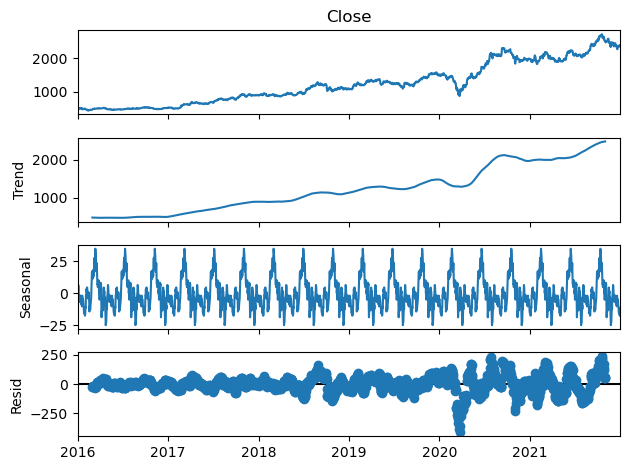

Days : 365


<Figure size 2000x1000 with 0 Axes>

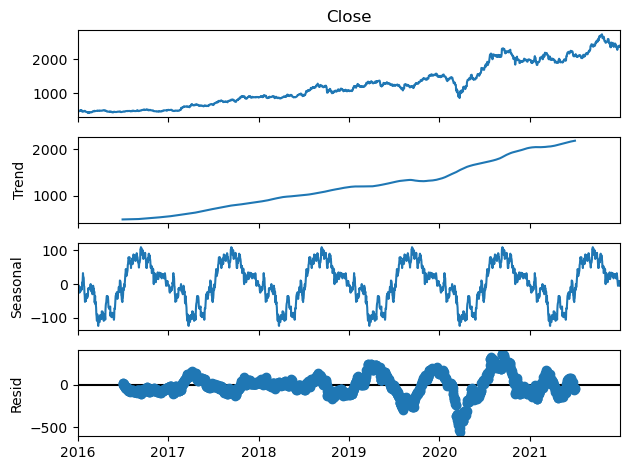

Days : 730


<Figure size 2000x1000 with 0 Axes>

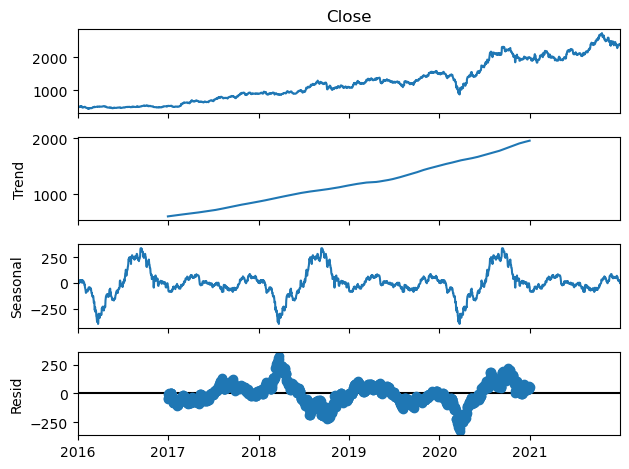

Days : 1095


<Figure size 2000x1000 with 0 Axes>

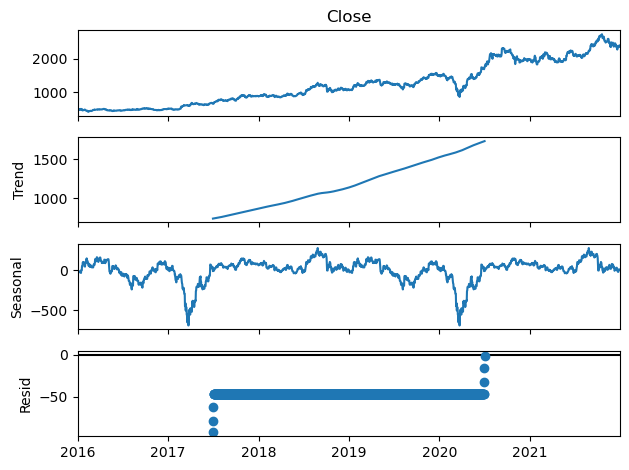

In [131]:
for period in [7, 30, 120, 365, 730, 1095]:
    print(f"Days : {period}")
    result = seasonal_decompose(latest['Close'], period = period)
    plt.figure(figsize=(20, 10))
    result.plot()
    plt.show()

C:\Users\harsh\AppData\Local\Temp\ipykernel_932\1841911924.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



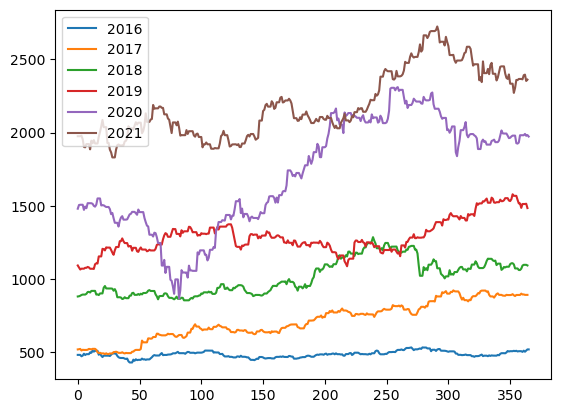

In [138]:
latest['year'] = latest.index.year
annual = latest.groupby('year')
for year, group in annual:
    group.reset_index()['Close'].plot(label = year)
plt.legend()

In [141]:
hist.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'macd', 'volatility',
       'Inflation', 'Lending_interest_rate', 'year'],
      dtype='object')

<Axes: xlabel='Volume', ylabel='Close'>

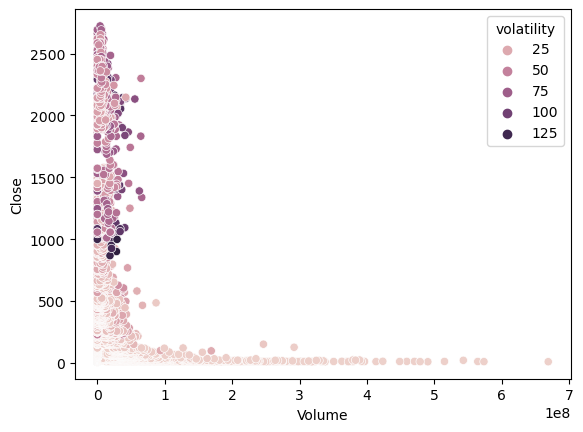

In [148]:
sns.scatterplot(hist, x = 'Volume', y = 'Close', hue = 'volatility')

<Axes: xlabel='Inflation', ylabel='Lending_interest_rate'>

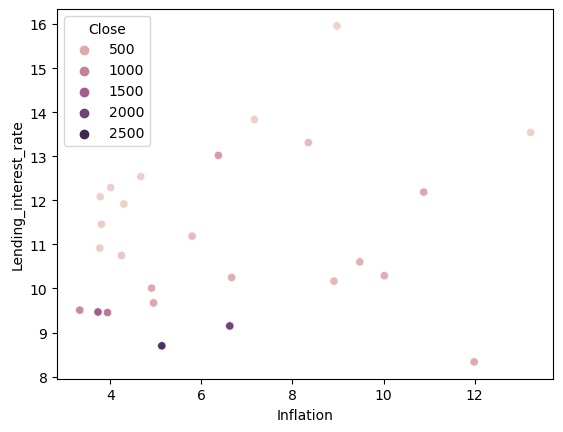

In [151]:
sns.scatterplot(hist, x = 'Inflation', y = 'Lending_interest_rate', hue = 'Close')

In [155]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

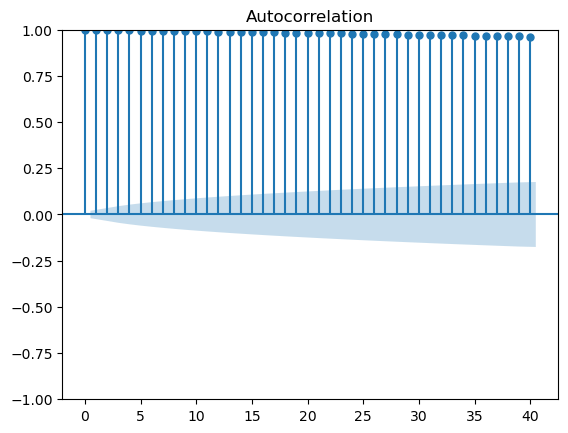

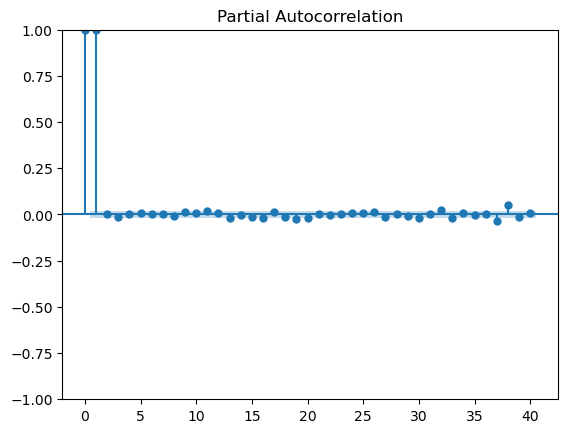

In [161]:
plot_acf(hist.Close)
plt.show()
plot_pacf(hist.Close)
plt.show()

---
## Model Building

In [167]:
from statsmodels.tsa.statespace import sarimax, kalman_filter
from statsmodels.tsa.arima.model import ARIMA

In [168]:
hist.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'macd', 'volatility',
       'Inflation', 'Lending_interest_rate', 'year'],
      dtype='object')

In [176]:
model = ARIMA(endog = hist[['Close']], 
              exog = hist[['Volume','rsi', 'macd', 'volatility', 'Inflation', 'Lending_interest_rate']], 
              order = (1,0,0),
              seasonal_order = (0,1,0,4))
results = model.fit()
results.summary()

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                           Close   No. Observations:                 9478
Model:             ARIMA(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood              -35206.940
Date:                         Sat, 17 Jun 2023   AIC                          70429.880
Time:                                 18:00:17   BIC                          70487.131
Sample:                             01-20-1996   HQIC                         70449.312
                                  - 12-31-2021                                         
Covariance Type:                           opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Volume                  1.29e-09   5.24e-09      0.246      0.806   -8.99e-09    1.16e-08
rsi                       0.1628      0.010     15.602      0.000       0.142       0.183
macd                      5.2826      0.026    203.049      0.000       5.232       5.334
volatility                0.0398      0.015      2.666      0.008       0.011       0.069
Inflation                -0.2477   2.58e-06   -9.6e+04      0.000      -0.248      -0.248
Lending_interest_rate     0.4998   9.08e-08    5.5e+06      0.000       0.500       0.500
ar.L1                     0.7328      0.002    310.559      0.000       0.728       0.737
sigma2                   98.9360      0.001   1.38e+05      0.000      98.935      98.937
===================================================================================
Ljung-Box (L1) (Q):                  21.61   Jarque-Bera (JB):            348334.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              98.73   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.64e+26. Standard errors may be unstable.
"""

In [207]:
hist['cbrt_close'] = np.cbrt(hist.Close)

<Axes: xlabel='Date'>

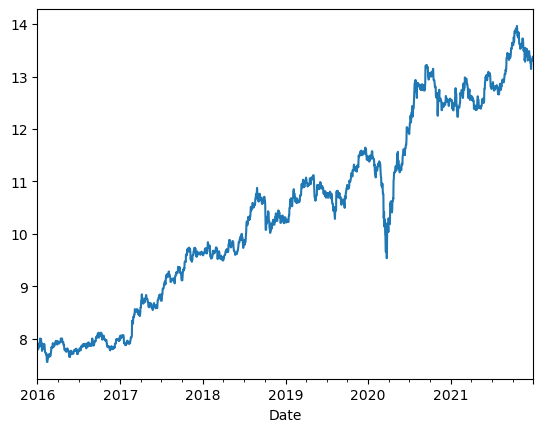

In [208]:
np.cbrt(latest.Close).plot()

In [190]:
from statsmodels.tsa.seasonal import STL, 

In [218]:
results = STL(hist.resample('M').mean().cbrt_close).fit()

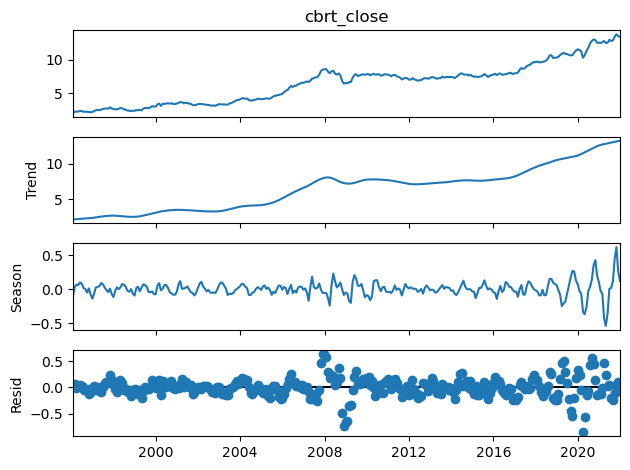

In [219]:
results.plot()
plt.show()

In [220]:
from statsmodels.tsa.seasonal import MSTL

<Figure size 1600x1600 with 0 Axes>

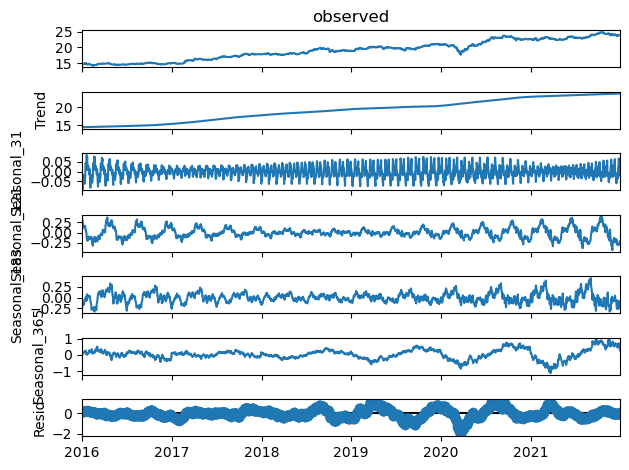

In [248]:
results = MSTL(latest.Close, periods = [31, 121, 183, 365], windows = [31, 121, 183, 365], lmbda = 0.25, iterate = 5).fit()
results.plot()
plt.show()